## Setup and Configuration

In [ ]:
# In case transformers needs to be installed (Google Colab does not permanently install packages)

#!pip install transformers

In [ ]:

import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import re
import string
import numpy as np
import pandas as pd
import seaborn as sns
import tqdm
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from google.colab import drive, files

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

Since Google Colab does not store imported datasets in memory unless you refer to them via a Google Drive path, I highly recommend copying the parent folder which contains all code and data files so that you can simply authenticate your Google Drive account with Google Colab and refer to the datasets and models:

*   ***compiled_dataset.csv*** — compiled dataset from dynasent and financial phrasebank datasets;
*   ***best_bert_model.bin*** — best version of the BERT transformer model trained on the compiled dataset;
*   ***btc_tweets.csv*** — Kaggle dataset with ~2.3M entries;
*   ***btc_prices.csv*** — ~1 year of BTC prices (February 2021 - February 2022);
*   ***btc_tweets_sentiment_1year.csv*** — Kaggle dataset with ~2.3M entries AND a column where every tweet's sentiment is classified;
*   ***btc_tweets_pos_neg_1year.csv*** — same as above except that entries with neutral sentiment are removed.

In [ ]:
# connect google drive for easy dataset imports

drive.mount('/content/drive')

Mounted at /content/drive


## Exploratory Data Analysis

In [ ]:
# take a look at the head of the data
df = pd.read_csv("/content/drive/MyDrive/Capstone/compiled_dataset.csv")
df.head()

,Text,Sentiment,Length
0,"According to Gran , the company has no plans t...",neutral,127
1,With the new production plant the company woul...,positive,206
2,"For the last quarter of 2010 , Componenta 's n...",positive,193
3,Operating profit rose to EUR 13.1 mn from EUR ...,positive,122
4,"Operating profit totalled EUR 21.1 mn , up fro...",positive,103


In [ ]:
# explore the raw dataset dimensions
df.shape

(99706, 3)

In [ ]:
# check for null entries
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99706 entries, 0 to 99705
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       99706 non-null  object
 1   Sentiment  99706 non-null  object
 2   Length     99706 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.3+ MB


In [ ]:
class EDA:
    """
    Performs EDA on a specified dataset.
    """
    def __init__(self, dataset):
        """
        dataset (Pandas DataFrame):
            dataset of interest
        """
        self.data = pd.read_csv(dataset)
        
    def plot_stats(self):
        """
        Outputs 2 plots:
            1. Histogram of text sentiments (3 types).
            2. Distribution of text lengths for every sentiment.
        """
        # histogram of text sentiments (3 types)
        sns.countplot(x = "Sentiment", data=self.data)
        plt.xlabel("Sentiment", size=15)
        plt.ylabel("Count", size=15)
        plt.title("Count of all tweet sentiments", size=17)
        plt.show()
        
        # distributions of text lengths for every sentiment
        grid = sns.FacetGrid(self.data, col = "Sentiment")
        grid.map(plt.hist, "Length")
        plt.show()
        
    def clean(self, method):
        """
        Cleans the dataset.
        -----------------------------
        method (str):
            sentiment analysis method
        """
        cleaned = []
        labels = []
        for text in self.data["Text"]:
            # remove unnecessary characters that do not impact the outcome
            # remove @ tags and links from the text
            text = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])" \
                                  "|(\w+:\/\/\S+)", " ", text).split()) 
            # convert all letters to lower case and replacing '-' with spaces.
            text = text.lower().replace('-', ' ')
            # remove stopwords and numbers
            table = str.maketrans('', '', string.punctuation+string.digits)
            text = text.translate(table)
            if method == "rule-based":
                # tokenize words 
                tokens = word_tokenize(text)
                # stem the words 
                stemmed = [porter.stem(word) for word in tokens]
                words = [w for w in stemmed if not w in n_words]
                text = ' '.join(words)
            cleaned.append(text)
        self.data["Text"] = np.array(cleaned)

In [ ]:
data_path = "/content/drive/MyDrive/Capstone/compiled_dataset.csv"
data = EDA(data_path)
data.clean(method="transformer")

In [ ]:
# explore the cleaned data
bert_data = data.data
bert_data.head()

,Text,Sentiment,Length
0,according to gran the company has no plans to ...,neutral,127
1,with the new production plant the company woul...,positive,206
2,for the last quarter of componenta s net sale...,positive,193
3,operating profit rose to eur mn from eur m...,positive,122
4,operating profit totalled eur mn up from eur...,positive,103


## Data Preprocessing

In [ ]:
def to_sentiment(sentiment):
    """
    Turns sentiment into an arbitrary label (0, 1, 2)
    ----------------
    sentiment (str):
        text sentiment (neutral, positive, negative)
    """
    if sentiment == "neutral":
        return 0
    elif sentiment == "positive":
        return 1
    else:
        return 2
bert_data['Label'] = bert_data["Sentiment"].apply(to_sentiment)
class_names = ['neutral', 'positive', 'negative']

In [ ]:
# initialize BERT tokenizer and BERT model
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',
                                                do_lower_case=True, 
                                                num_labels = 3)
bert_model = BertModel.from_pretrained('bert-base-uncased', num_labels = 3)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# find the token length of each review to determine max length 
# (will be utilized later during tokenization)
tokens_arr = []
for txt in bert_data["Text"]:
    tokens = bert_tokenizer.encode(txt, max_length=500)
    tokens_arr.append(len(tokens))

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


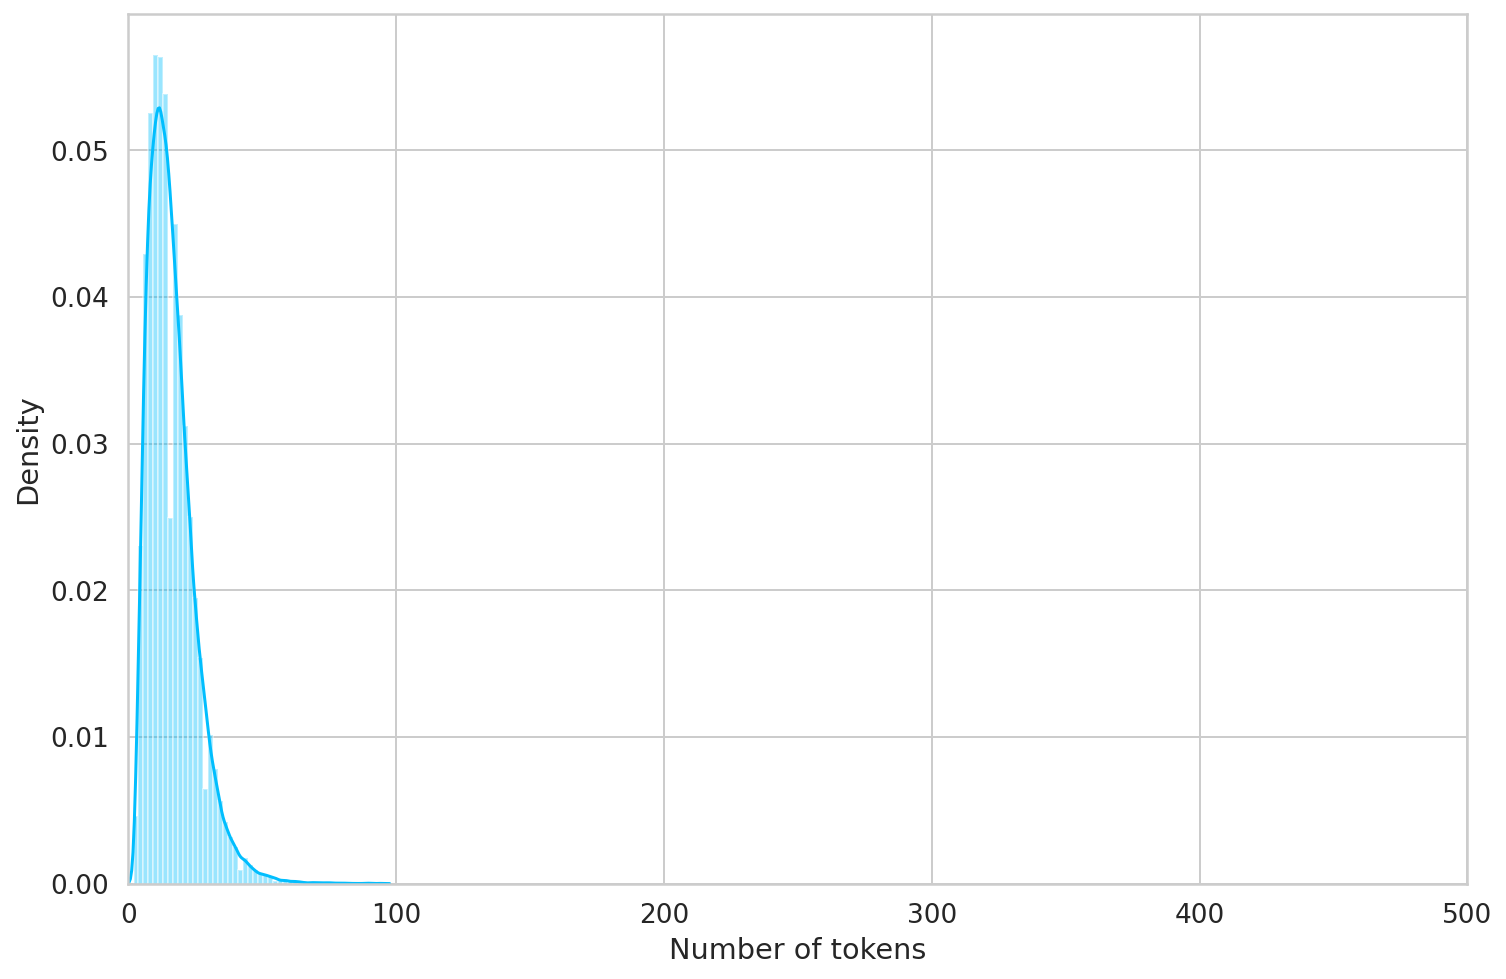

In [ ]:
sns.distplot(tokens_arr)
plt.xlim([0, 500]);
plt.xlabel('Number of tokens')
plt.show()

In [ ]:
MAX_LEN = 100

class GPReviewDataset(Dataset):
    """
    Creates a dataset of tokenized entries in a format suitable for BERT model.
    """
    def __init__(self, reviews, targets, tokenizer, max_len):
        """
        reviews (Pandas DataFrame):
            compiled dataset reviews
        targets (Pandas DataFrame):
            outcome variable (pre-labeled sentiment)
        tokenizer (BertTokenizer object):
            tokenizer that turns text input into a machine-friendly form
        max_len (int):
            maximum length of a tokenized sequence
        
        """
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        """
        Returns the size of the input column.
        """
        return len(self.reviews)

    def __getitem__(self, item):
        """
        Compiles input, output, and encoded data together.
        -------------------
        Returns:
            a dictionary containing the objects specified above.
        """
        review = str(self.reviews[item])
        target = self.targets[item]
        encoding = self.tokenizer.encode_plus(review,
                                              add_special_tokens=True,
                                              max_length=self.max_len,
                                              return_token_type_ids=False,
                                              padding='max_length',
                                              return_attention_mask=True,
                                              return_tensors='pt')
        
        return {'review_text': review,
                'input_ids': encoding['input_ids'].flatten(),
                'attention_mask': encoding['attention_mask'].flatten(),
                'targets': torch.tensor(target, dtype=torch.long)}

In [ ]:
# split the data into train, validation, test sets (90%, 5%, 5% respectively)
df_train, df_test = train_test_split(bert_data,
                                     test_size=0.1,
                                     random_state=RANDOM_SEED, 
                                     stratify=bert_data["Label"])

df_val, df_test = train_test_split(df_test,
                                   test_size=0.5,
                                   random_state=RANDOM_SEED,
                                   stratify=df_test["Label"])
df_train.shape, df_val.shape, df_test.shape

((89735, 4), (4985, 4), (4986, 4))

In [ ]:
BATCH_SIZE = 16
def create_data_loader(df, tokenizer, max_len, batch_size):
    """
    Creates DataLoader objects for train/validation/test sets.
    ---------------------------------
    tokenizer (BertTokenizer object):
        tokenizer that turns text input into a machine-friendly form
    max_len (int):
        maximum length of a tokenized sequence
    batch_size (int):
        the number of training examples utilized in one iteration
    """
    ds = GPReviewDataset(reviews=df["Text"].to_numpy(),
                         targets=df["Label"].to_numpy(),
                         tokenizer=bert_tokenizer,
                         max_len=max_len)
    
    return DataLoader(ds, batch_size=batch_size,num_workers=4)

In [ ]:
train_data_loader = create_data_loader(df_train, bert_tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, bert_tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, bert_tokenizer, MAX_LEN, BATCH_SIZE)

## Sentiment Classification

In [ ]:
class SentimentClassifier(nn.Module):
    """
    Creates Bert model architecture.
    """
    def __init__(self, n_classes):
        """
        bert (BertModel object):
            BERT model
        drop (nn.Dropout object):
            percentage of neurons that are removed in every layer for regularization
        out (nn.Linear object):
            defines the output format based on the number of classes (3)
        
        """
        super(SentimentClassifier, self).__init__()
        self.bert = bert_model
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        """
        Runs through model architecture layer-by-layer.
        ------------------------------
        input_ids (arr):
            list of tokens that represent words
        attention_mask (arr):
            a combination of 0s (pad tokens) and 1 (real tokens)
        """
        _, pooled_output = self.bert(input_ids=input_ids,
                                     attention_mask=attention_mask,
                                     return_dict=False)
        
        output = self.drop(pooled_output)
        return self.out(output)

In [ ]:
# initialize the model
model = SentimentClassifier(len(class_names))
model = model.to(device)

### Training

In [ ]:
# number of training iterations
EPOCHS = 5
# Adam algorithm with weight decay fix
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=total_steps)
# penalizes the outcome probability based on how far it is from the actual expected value
loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    """
    Performs training of 1 epoch.
    ---------------------------------
    model (BertModel object):
        bert model
    data_loader (DataLoader object)
        train/validation set data loader
    loss_fn (CrossEntropyLoss object):
        loss function
    optimizer (AdamW object):
        model optimizer
    device (cuda object):
        GPU
    scheduler:
        helps start model training
    n_examples: 
        dataset size
    --------------------------------
    Returns:
        model accuracy, mean model loss
    """
    model = model.train()

    losses = []
    correct_predictions = 0
  
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    """
      Evaluates model performance.
      ---------------------------------
      model (BertModel object):
          bert model
      data_loader (DataLoader object)
          train/validation set data loader
      loss_fn (CrossEntropyLoss object):
          loss function
      device (cuda object):
          GPU
      n_examples: 
          dataset size
      --------------------------------
      Returns:
          model accuracy, mean model loss
      """

    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)

            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time

# place to store training history
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 5)
    # train the epoch
    train_acc, train_loss = train_epoch(model, train_data_loader, loss_fn, 
                                        optimizer, device, scheduler, len(df_train))

    print(f'Train loss {train_loss} accuracy {train_acc}')
    # evaluate the epoch
    val_acc, val_loss = eval_model(model, val_data_loader, loss_fn, device, len(df_val))

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()
    # save training/validation history
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    # update validation accuracy if necessary
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        
        best_accuracy = val_acc

Epoch 1/5
-----
Train loss 0.6197010523153618 accuracy 0.7444698278263777
Val   loss 0.5756986470272144 accuracy 0.7695085255767301

Epoch 2/5
-----
Train loss 0.4174117635810018 accuracy 0.8406084582381457
Val   loss 0.682937998814174 accuracy 0.7648946840521564

Epoch 3/5
-----
Train loss 0.2778523456237438 accuracy 0.905466094611913
Val   loss 0.8754367106474745 accuracy 0.7669007021063189

Epoch 4/5
-----
Train loss 0.1991278026719352 accuracy 0.9418732935866719
Val   loss 1.0722409730705504 accuracy 0.7658976930792377

Epoch 5/5
-----
Train loss 0.1489140024741257 accuracy 0.9594472613807322
Val   loss 1.2674529203512253 accuracy 0.7681043129388164

CPU times: user 1h 34min 19s, sys: 38min 20s, total: 2h 12min 40s
Wall time: 2h 13min 10s


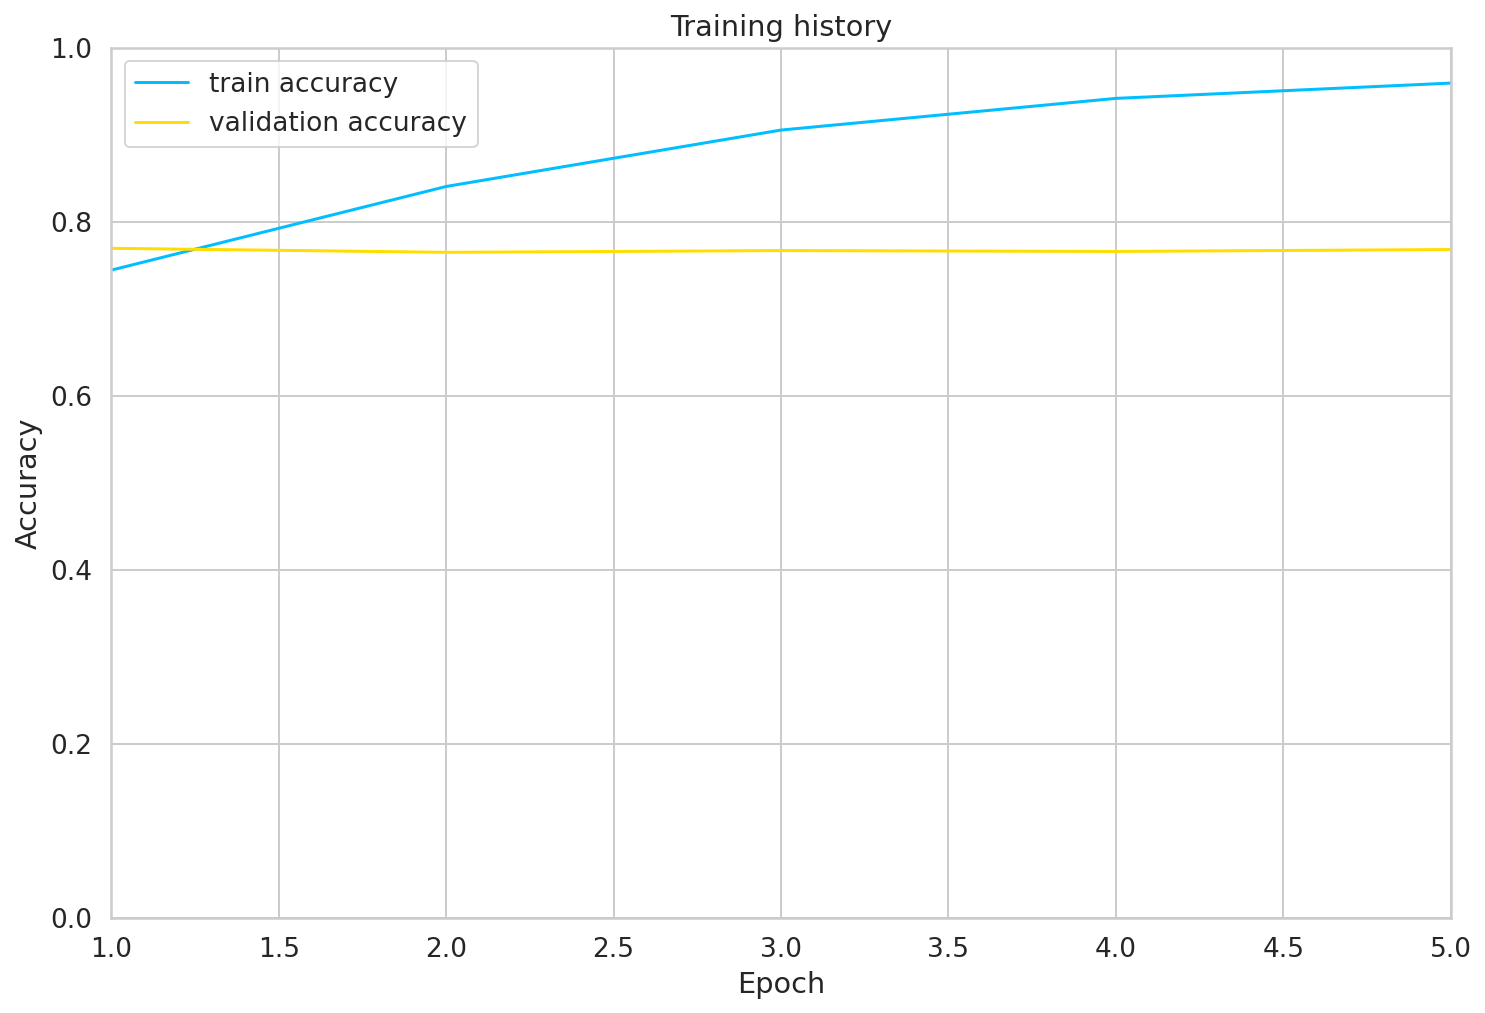

In [ ]:
train_acc = torch.FloatTensor(history["train_acc"])
val_acc = torch.FloatTensor(history["val_acc"])

plt.plot(list(range(1, len(train_acc)+1)),train_acc, label='train accuracy')
plt.plot(list(range(1, len(val_acc)+1)), val_acc, label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim([0, 1])
plt.xlim([1, 5])
plt.legend()
plt.show()


Note that we're storing the state of the best model, indicated by the highest validation accuracy.

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Capstone/best_bert_model.bin')
files.download('/content/drive/MyDrive/Capstone/best_bert_model.bin')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In case there is no time to train the transformer model, please uncomment the code cell below. The code uses best model state to restore the weights and get the model ready for predictions.

In [ ]:
class_names = ['neutral', 'positive', 'negative']
model = SentimentClassifier(len(class_names))
model.load_state_dict(torch.load('/content/drive/MyDrive/Capstone/best_bert_model.bin'))
model = model.to(device)

## Evaluation

In [ ]:
test_acc, _ = eval_model(model, test_data_loader, loss_fn, device, len(df_test))

print(f"Accuracy on the test set: {round(test_acc.item(), 4)*100}%")

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Accuracy on the test set: 78.34%


The accuracy is about 2% higher on the test set compared to the validation set. This signals that the model is able to generalize.

In [ ]:
def get_predictions(model, data_loader):
    """
    Outputs predicted sentiment labels.
    --------------------
    model (BertModel object):
          bert model
    data_loader (DataLoader object)
        train/validation set data loader
    --------------------
    Returns:
        initial text (arr), predictions (arr), 
        prediction probabilities (arr), initial target values (arr)
    """
    model = model.eval()
    
    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:

            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)

            probs = F.softmax(outputs, dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return review_texts, predictions, prediction_probs, real_values

In [ ]:
# store the text of the reviews and the predicted probabilities
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model, test_data_loader)

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

     neutral       0.82      0.83      0.83      2491
    positive       0.76      0.76      0.76      1470
    negative       0.72      0.70      0.71      1025

    accuracy                           0.78      4986
   macro avg       0.77      0.76      0.77      4986
weighted avg       0.78      0.78      0.78      4986



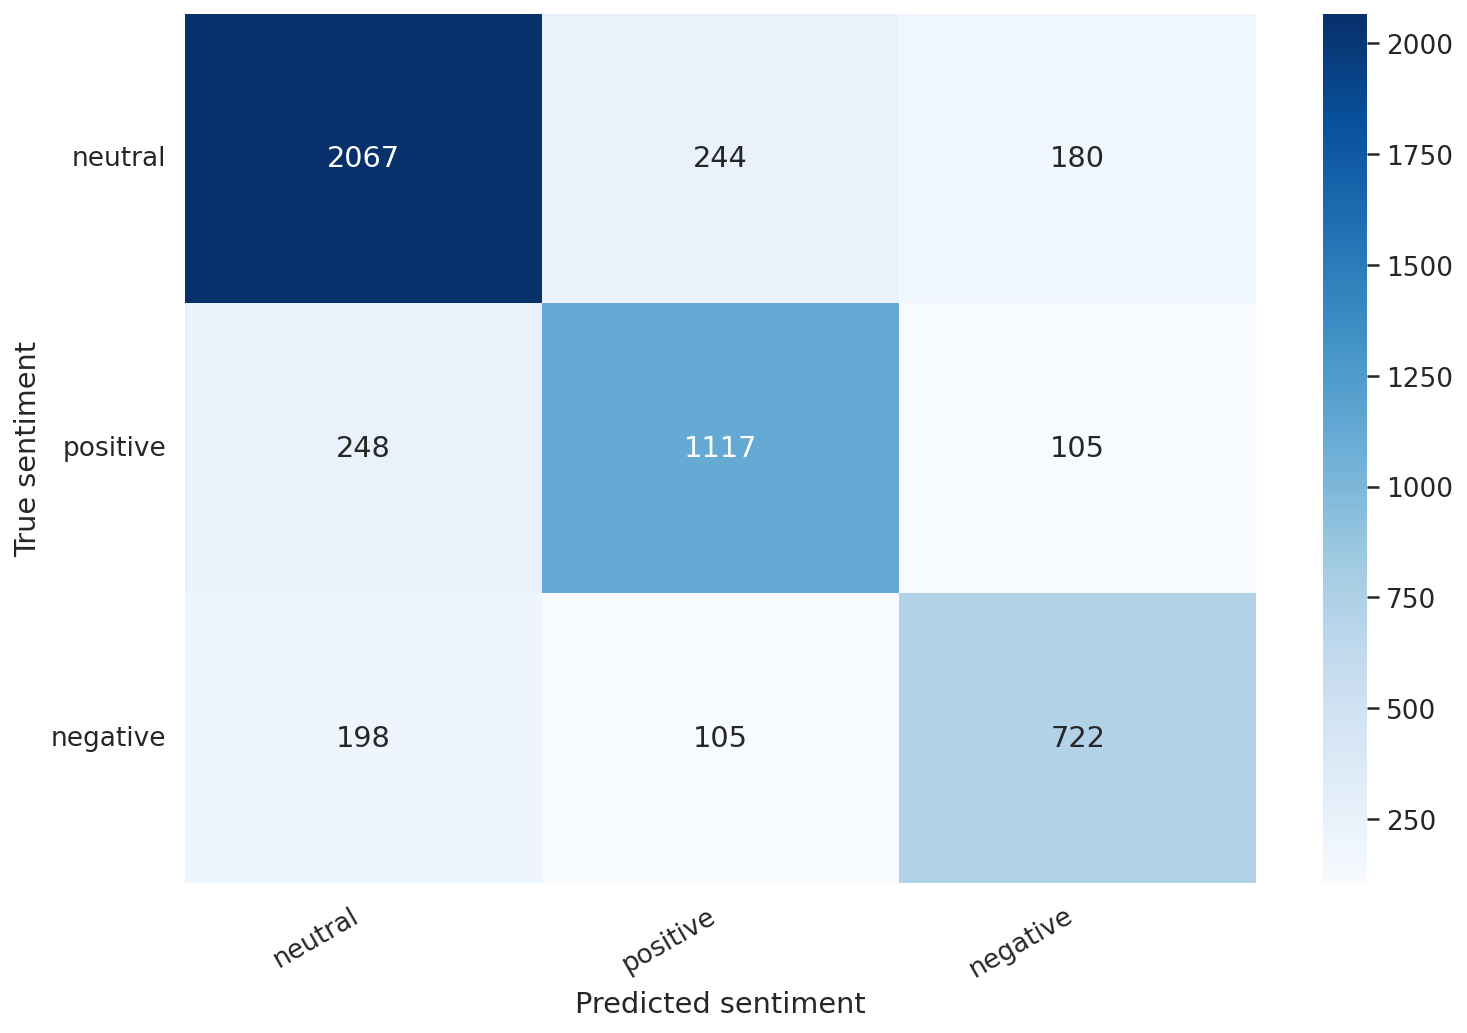

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

## Predicting the Sentiment on a Real Dataset of Bitcoin Tweets

In [ ]:
btc_tweets = pd.read_csv("/content/drive/MyDrive/Capstone/btc_tweets.csv")

In [ ]:
btc_prices = pd.read_csv("/content/drive/MyDrive/Capstone/btc_prices.csv")

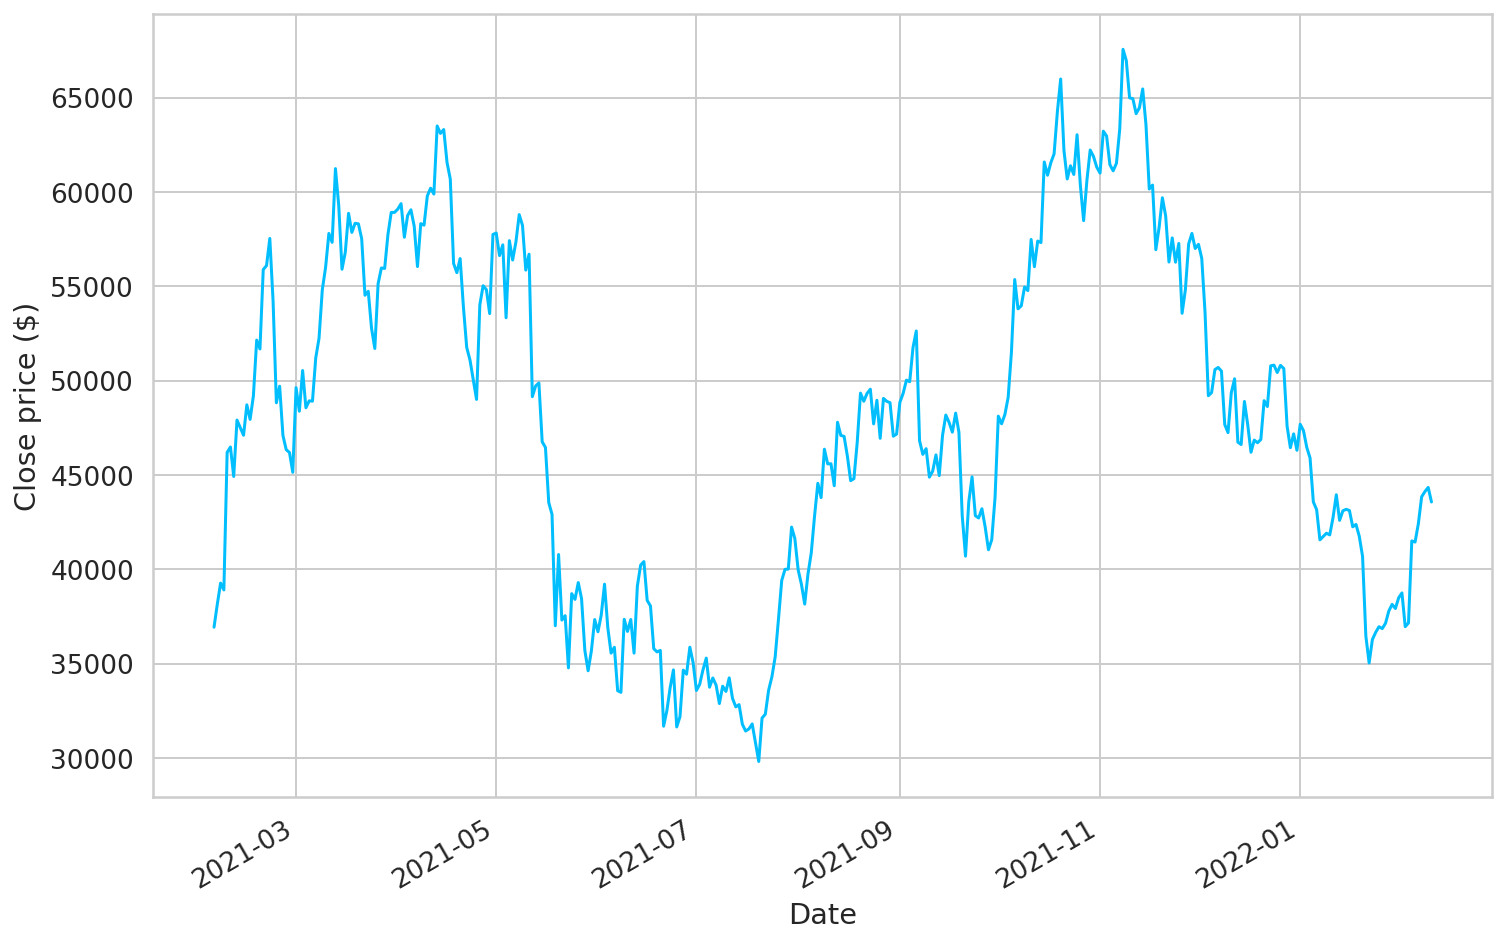

In [ ]:
import matplotlib.dates as mdates
fig, ax = plt.subplots()
ax.plot(pd.to_datetime(btc_prices["Date"]), btc_prices["Close"])
# Rotate and align the tick labels so they look better.
fig.autofmt_xdate()
# Use a more precise date string for the x axis locations in the toolbar.
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
plt.xlabel("Date")
plt.ylabel("Close price ($)")
plt.show()

In [ ]:
btc_tweets.drop("Unnamed: 0", axis=1, inplace=True)
btc_tweets.dropna(inplace=True)

In [ ]:
btc_prices.drop("Unnamed: 0", axis=1, inplace=True)

In [ ]:
def classify_sentiment(df, to_process, start_row):
    """
    Calculates the sentiment of Bitcoin tweet data (similar to get_predictions()).
    Saves the batch as a Numpy array in a separate text file.
    ------------------------
    df (Pandas DataFrame):
        input dataframe
    to_process (int):
        number of rows to process
    start_row (int):
        row index to start from
    """
    sentiments = []
    # iterate through all tweets in the dataset
    for tweet in tqdm.tqdm(df.iloc[start_row:start_row+to_process, 1]):
        # encode every sample
        encoded_review = bert_tokenizer.encode_plus(tweet, max_length=100,
                                                    add_special_tokens=True,
                                                    return_token_type_ids=False,
                                                    pad_to_max_length=True,
                                                    return_attention_mask=True,
                                                    return_tensors='pt')
        # store input ids and attention mask values
        input_ids = encoded_review['input_ids'].to(device)
        attention_mask = encoded_review['attention_mask'].to(device)

        # initialize BERT model with the help of input ids and attention mask values
        result = model(input_ids, attention_mask)
        # predict the sentiment for the given tweet
        _, prediction = torch.max(result, dim=1)
        # classify the sentiment according to 3 categories
        if class_names[prediction] == "positive":
            sentiments.append(1)
        elif class_names[prediction] == "neutral":
            sentiments.append(0)
        else:
            sentiments.append(-1)

    # download a specific subset after prediction is finished
    fname = str(start_row) + ".txt"
    np.savetxt(fname, sentiments, fmt="%d")
    files.download(fname)

Processing the whole dataset and predicting a sentiment for every tweet might be challenging because it requires a lot of time. Depending on the runtime used (CPU/GPU/TPU), the execution time could range from 12 hours to a week. Thus, if you were to reproduce this code, I recommend selecting **GPU** as a runtime and breaking the dataset into batches (see **bert_subsets** folder). These batches represent parts of the dataset and allow a smoother testing process because Google Colab tends to stop execution if it detects that a user's machine is inactive (meaning that you have to sit and check every 30-60 mins that your code is running and doing so during 12 hours might be more problematic than during 1-2 hour periods).

In [ ]:
classify_sentiment(btc_tweets, 2233441, 0)

In [ ]:
import os 
os.listdir("/content/drive/MyDrive/Capstone/bert_subsets/")

['0.txt',
 '200000.txt',
 '700000.txt',
 '900000.txt',
 '1100000.txt',
 '1700000.txt']

In [ ]:
path = "/content/drive/MyDrive/Capstone/bert_subsets/"
subsets = []
for s in os.listdir(path):
    print(f"Processing results in {s}")
    subset = np.loadtxt(path+s, dtype=int)
    subsets.append(subset)

Processing results in 0.txt
Processing results in 200000.txt
Processing results in 700000.txt
Processing results in 900000.txt
Processing results in 1100000.txt
Processing results in 1700000.txt


In [ ]:
# merge the classified subsets
merged_sentiments = np.concatenate(subsets, axis=0)

In [ ]:
# add a column of newly classified sentiment to BTC tweet dataset
btc_tweets["Sentiment"] = merged_sentiments

In [ ]:
# save the dataset to the Google Drive folder
btc_tweets.to_csv("/content/drive/MyDrive/Capstone/btc_tweets_sentiment_1year.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
btc_tweets = pd.read_csv("/content/drive/MyDrive/Capstone/btc_tweets_sentiment_1year.csv")

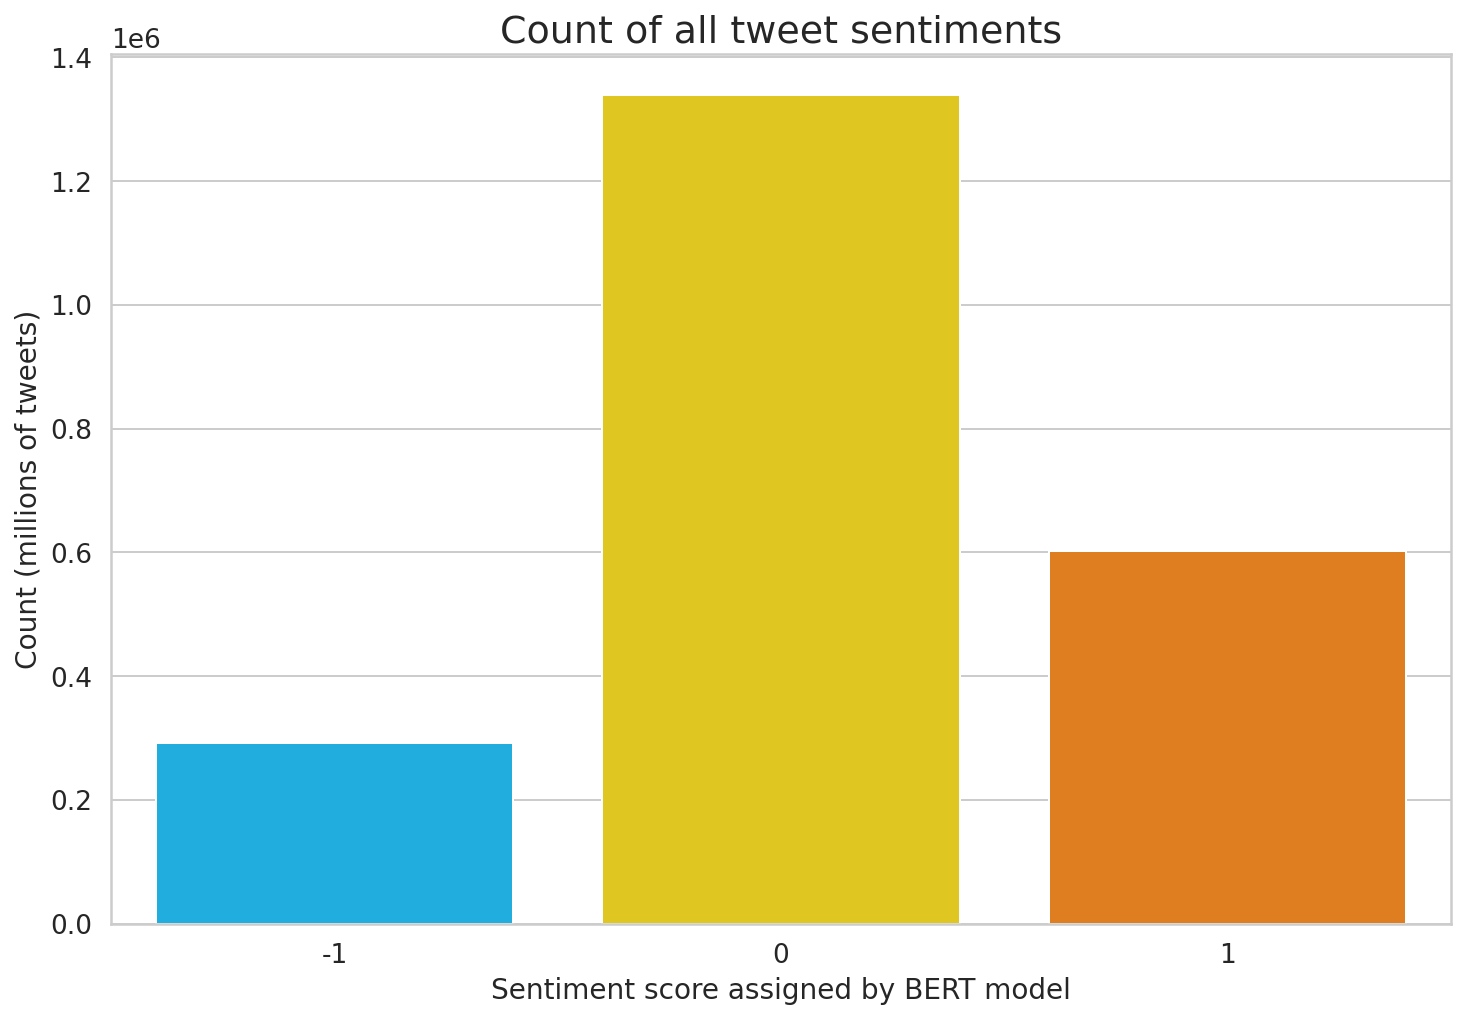

In [ ]:
sns.countplot(x = "Sentiment", data=btc_tweets)
plt.xlabel("Sentiment score assigned by BERT model", size=14)
plt.ylabel("Count (millions of tweets)", size=14)
plt.title("Count of all tweet sentiments", size=19)
plt.show()

In [ ]:
btc_tweets_pos_neg = btc_tweets.copy()

In [ ]:
# remove the neutral tweets from the dataset as they do not
# contribute to bitcoin fluctuations according to our research design
btc_tweets_pos_neg.drop(btc_tweets_pos_neg.loc[btc_tweets_pos_neg['Sentiment']==0].index, 
                        inplace=True)
print(f"Dataset size without neutral tweets: {btc_tweets_pos_neg.shape[0]} rows, " \
      f"{btc_tweets_pos_neg.shape[1]} columns")


Dataset size without neutral tweets: 894521 rows, 3 columns


In [ ]:
# save the dataset with classified tweets that are either positive or negative
btc_tweets_pos_neg.to_csv("/content/drive/MyDrive/Capstone/btc_tweets_pos_neg_1year.csv")

In [ ]:
btc_tweets_pos_neg = pd.read_csv("/content/drive/MyDrive/Capstone/btc_tweets_pos_neg_1year.csv")

In [ ]:
btc_tweets_pos_neg["date"] = pd.to_datetime(btc_tweets_pos_neg["date"]).dt.date

## Defining lags of different lengths

In [ ]:
# group entries by date and take the mean sentiment score for each day
btc_tweets_lagged = btc_tweets_pos_neg.groupby("date", as_index=False)["Sentiment"].mean()

In [ ]:
btc_tweets_lagged.index = np.arange(1, len(btc_tweets_lagged)+1)
btc_prices.index = np.arange(1, len(btc_prices)+1)

In [ ]:
btc_tweets_lagged.head(10)

,date,Sentiment
1,2021-02-05,0.221996
2,2021-02-06,0.277034
3,2021-02-07,0.404455
4,2021-02-08,0.313692
5,2021-02-09,0.338674
6,2021-02-10,0.316804
7,2021-02-13,0.265442
8,2021-02-14,-0.179575
9,2021-02-15,-0.480793
10,2021-02-18,0.263309


In [ ]:
btc_prices.head(10)

,Date,Close
1,2021-02-04,36926.064465
2,2021-02-05,38144.306863
3,2021-02-06,39266.010735
4,2021-02-07,38903.441480
5,2021-02-08,46196.463719
6,2021-02-09,46481.104236
7,2021-02-10,44918.184492
8,2021-02-11,47909.331195
9,2021-02-12,47504.851183
10,2021-02-13,47105.517473


In [ ]:
# copy the same structure to the cases with longer lags 
# (we anticipate the same number of data points (~365))
btc_tweets_lagged1 = btc_tweets_lagged.copy().iloc[6:, :]
btc_tweets_lagged3 = btc_tweets_lagged.copy().iloc[6:, :]
btc_tweets_lagged5 = btc_tweets_lagged.copy().iloc[6:, :]
btc_tweets_lagged7 = btc_tweets_lagged.copy().iloc[6:, :]

In [ ]:
def aggregate_sentiment(lag):
    """
    Calculates the aggregate sentiment based on the input lag.
    ------------------------
    lag (int):
        data lag (in days)
    """
    agg_scores = []
    start, end = 6-lag+1, 6
    for d in btc_tweets_lagged.iloc[6:, 1]:
        temp_score = 0
        for i in range(start, end+1):
            temp_score += btc_tweets_lagged.iloc[i, 1]
        agg_scores.append(temp_score/lag)
        start += 1
        end += 1
    return np.array(agg_scores)


In [ ]:
def add_btc_prices(lag):
    """
    Adds BTC prices (current and lagged) to the BTC tweet dataset.
    ------------------------
    lag (int):
        data lag (in days)
    """
    close_prices = []
    prices_lagged = []
    for d in btc_tweets_lagged.iloc[6:, 0]:
        date_only = str(d)
        close_price = btc_prices.loc[btc_prices["Date"] == date_only]["Close"]
        close_prices.append(close_price)
        prices_lagged.append(btc_prices["Close"].iloc[close_price.index-(lag+1)])

    return np.array(close_prices), np.array(prices_lagged)

In [ ]:
close, lag_1day = add_btc_prices(1)
btc_tweets_lagged1["Close Price"] = close
btc_tweets_lagged1["Price (day-1)"] = lag_1day
btc_tweets_lagged1["Price Difference"] = btc_tweets_lagged1["Close Price"] - \
btc_tweets_lagged1["Price (day-1)"]

In [ ]:
btc_tweets_lagged1.head()

,date,Sentiment,Close Price,Price (day-1),Price Difference
7,2021-02-13,0.265442,47105.517473,47504.851183,-399.333711
8,2021-02-14,-0.179575,48717.290211,47105.517473,1611.772739
9,2021-02-15,-0.480793,47945.056832,48717.290211,-772.233379
10,2021-02-18,0.263309,51679.796694,52149.007536,-469.210841
11,2021-02-19,0.300069,55888.133682,51679.796694,4208.336988


In [ ]:
close, lag_3day = add_btc_prices(3)
score_3day = aggregate_sentiment(3)
btc_tweets_lagged3["Sentiment"] = score_3day
btc_tweets_lagged3["Close Price"] = close
btc_tweets_lagged3["Price (day-3)"] = lag_3day
btc_tweets_lagged3["Price Difference"] = btc_tweets_lagged3["Close Price"] - \
btc_tweets_lagged3["Price (day-3)"]

In [ ]:
btc_tweets_lagged3.head()

,date,Sentiment,Close Price,Price (day-3),Price Difference
7,2021-02-13,0.306974,47105.517473,44918.184492,2187.332981
8,2021-02-14,0.134224,48717.290211,47909.331195,807.959016
9,2021-02-15,-0.131642,47945.056832,47504.851183,440.205649
10,2021-02-18,-0.132353,51679.796694,47945.056832,3734.739862
11,2021-02-19,0.027529,55888.133682,49199.871344,6688.262339


In [ ]:
close, lag_5day = add_btc_prices(5)
score_5day = aggregate_sentiment(5)
btc_tweets_lagged5["Sentiment"] = score_5day
btc_tweets_lagged5["Close Price"] = close
btc_tweets_lagged5["Price (day-5)"] = lag_5day
btc_tweets_lagged5["Price Difference"] = btc_tweets_lagged5["Close Price"] - \
btc_tweets_lagged5["Price (day-5)"]

In [ ]:
btc_tweets_lagged5.head()

,date,Sentiment,Close Price,Price (day-5),Price Difference
7,2021-02-13,0.327814,47105.517473,46196.463719,909.053753
8,2021-02-14,0.211007,48717.290211,46481.104236,2236.185975
9,2021-02-15,0.052111,47945.056832,44918.184492,3026.872340
10,2021-02-18,0.037038,51679.796694,47105.517473,4574.279222
11,2021-02-19,0.033691,55888.133682,48717.290211,7170.843471


In [ ]:
close, lag_7day = add_btc_prices(7)
score_7day = aggregate_sentiment(7)
btc_tweets_lagged7["Sentiment"] = score_7day
btc_tweets_lagged7["Close Price"] = close
btc_tweets_lagged7["Price (day-7)"] = lag_7day
btc_tweets_lagged7["Price Difference"] = btc_tweets_lagged7["Close Price"] - \
btc_tweets_lagged7["Price (day-7)"]

In [ ]:
btc_tweets_lagged7.head()

,date,Sentiment,Close Price,Price (day-7),Price Difference
7,2021-02-13,0.305443,47105.517473,39266.010735,7839.506738
8,2021-02-14,0.248075,48717.290211,38903.441480,9813.848731
9,2021-02-15,0.139814,47945.056832,46196.463719,1748.593113
10,2021-02-18,0.119651,51679.796694,47909.331195,3770.465500
11,2021-02-19,0.117705,55888.133682,47504.851183,8383.282499


## Model Accuracy

In [ ]:
def sentiment_to_movement(ds, lag_duration):
    """
    Counts the number of matches between the sentiment and movement direction.
    ---------------------------
    ds (Pandas DataFrame):
        updaded dataset of BTC tweets
    """
    aligned = 0
    for idx in ds.index:
        if ds["Sentiment"][idx] > 0 and ds["Price Difference"][idx] > 0:
            aligned += 1
        elif ds["Sentiment"][idx] < 0 and ds["Price Difference"][idx] < 0:
            aligned += 1
    print(f"Movement prediction accuracy ({lag_duration}-day lag): " \
          f"{round(aligned/ds.shape[0], 4)*100}%")


In [ ]:
sentiment_to_movement(btc_tweets_lagged1, 1)
sentiment_to_movement(btc_tweets_lagged3, 3)
sentiment_to_movement(btc_tweets_lagged5, 5)
sentiment_to_movement(btc_tweets_lagged7, 7)

Movement prediction accuracy (1-day lag): 54.81%
Movement prediction accuracy (3-day lag): 46.150000000000006%
Movement prediction accuracy (5-day lag): 50.0%
Movement prediction accuracy (7-day lag): 51.92%


## Correlation between Sentiment and Price Movement

In [ ]:
corr_1day = btc_tweets_lagged1["Sentiment"].corr(btc_tweets_lagged1["Price Difference"])
print(f"Correlation between the tweet sentiments and BTC price movements " \
      f"(1-day difference) is: {round(corr_1day, 2)}")
corr_3day = btc_tweets_lagged3["Sentiment"].corr(btc_tweets_lagged3["Price Difference"])
print(f"Correlation between the tweet sentiments and BTC price movements " \
      f"(3-day difference) is: {round(corr_3day, 2)}")
corr_5day = btc_tweets_lagged5["Sentiment"].corr(btc_tweets_lagged5["Price Difference"])
print(f"Correlation between the tweet sentiments and BTC price movements " \
      f"(5-day difference) is: {round(corr_5day, 2)}")
corr_7day = btc_tweets_lagged7["Sentiment"].corr(btc_tweets_lagged7["Price Difference"])
print(f"Correlation between the tweet sentiments and BTC price movements " \
      f"(7-day difference) is: {round(corr_7day, 2)}")

Correlation between the tweet sentiments and BTC price movements (1-day difference) is: 0.31
Correlation between the tweet sentiments and BTC price movements (3-day difference) is: 0.19
Correlation between the tweet sentiments and BTC price movements (5-day difference) is: 0.24
Correlation between the tweet sentiments and BTC price movements (7-day difference) is: 0.28


## References

- [BERT Fine-Tuning Tutorial with PyTorch](https://mccormickml.com/2019/07/22/BERT-fine-tuning/)
- [How to Fine-Tune BERT for Text Classification?](https://arxiv.org/pdf/1905.05583.pdf)
- [BERT Explained: State of the art language model for NLP](https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270)